In [1]:
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.8 MB/s eta 0:00:00


In [8]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import wfdb
import os

In [3]:
# Toy dataset
# Set random seed for reproducibility
torch.manual_seed(42)

# Example data (replace with actual ECG data)
N = 1000  # Number of samples
s = torch.randn(N, 1)  # Simulated reference ECG signal (s(t))
B = torch.ones(N, 1) * 0.5  # Constant magnetic field (B), assumed to be 0.5 T
d = s + 0.1 * torch.sin(2 * torch.pi * torch.linspace(0, 1, N).view(-1, 1))  # Simulated corrupted ECG
s_obs = s  # The true reference ECG for validation (or comparison)


In [4]:
# Model
# Define PINN reconstruction model
class ReconstructNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(ReconstructNN, self).__init__()

    # Layers
    self.network = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.Tanh(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.Tanh(),
        nn.Linear(hidden_dim, output_dim)
    )

  def forward(self, d, B):
    # d = corrupted ECG, B = magnetic field
    x = torch.cat([d, B], dim = 1)
    return self.network(x)

# Define physics-informed loss function
def physics_loss(d, s, B, model, alpha):

  # Predicted reconstructed ECG signal
  s_pred = model(d, B)

  # Distortion = d - s_pred = alpha * f(s(t)) * B
  distortion = d - s_pred

  # Physics-loss
  mhd_loss = torch.mean((distortion - alpha * s_pred * B) ** 2)

  return mhd_loss

# Define data loss
def data_loss(s_pred, s_obs):
  return torch.mean((s_pred - s_obs) ** 2)

# Define total loss
def total_loss(d, s, B, s_obs, model, alpha, lambda_data, lambda_physics):

  # Calculate predicted signal
  s_pred = model(d, B)

  # Calculate data loss
  loss_data = data_loss(s_pred, s_obs)

  # Calculate physics loss
  loss_physics = physics_loss(d, s, B, model, alpha)

  # Calculate total loss
  loss_total = lambda_data * loss_data + lambda_physics * loss_physics

  return loss_total

In [5]:
# Training
def train_model(model, d, s, B, s_obs, alpha, lambda_data, lambda_physics, epochs = 1000, lr = 1e-3):
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  for epoch in range(epochs):
    optimizer.zero_grad()

    # Calculate total loss
    loss = total_loss(d, s, B, s_obs, model, alpha, lambda_data, lambda_physics)

    # Backpropagation
    loss.backward()

    # Update model parameters
    optimizer.step()

    if epoch % 100 == 0:
      print(f'Epoch {epoch}, Loss: {loss.item()}')

  return model

In [6]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Example data (replace with actual ECG data)
N = 1000  # Number of samples
s = torch.randn(N, 1)  # Simulated reference ECG signal (s(t))
B = torch.ones(N, 1) * 0.5  # Constant magnetic field (B), assumed to be 0.5 T
d = s + 0.1 * torch.sin(2 * torch.pi * torch.linspace(0, 1, N).view(-1, 1))  # Simulated corrupted ECG
s_obs = s  # The true reference ECG for validation (or comparison)

# Hyperparameters
input_dim = 2  # Inputs: corrupted ECG d(t), magnetic field B
hidden_dim = 50  # Hidden layer size
output_dim = 1  # Output: reconstructed reference ECG s(t)
alpha = 0.1  # Scaling factor for the distortion term
lambda_data = 1.0  # Weight for the data loss
lambda_physics = 1.0  # Weight for the physics loss

# Initialize the model
model = ReconstructNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

# Train the model
train_model(model, d, s, B, s_obs, alpha, lambda_data, lambda_physics, epochs=1000, lr=1e-3)

# After training, you can use the model to predict the reference ECG:
s_pred = model(d, B)
print("Predicted reference ECG:", s_pred[:5])

Epoch 0, Loss: 2.3391807079315186
Epoch 100, Loss: 0.029147472232580185
Epoch 200, Loss: 0.015817541629076004
Epoch 300, Loss: 0.00908542238175869
Epoch 400, Loss: 0.0069314418360590935
Epoch 500, Loss: 0.006501961965113878
Epoch 600, Loss: 0.006361327599734068
Epoch 700, Loss: 0.006265397649258375
Epoch 800, Loss: 0.006185309030115604
Epoch 900, Loss: 0.006116444244980812
Predicted reference ECG: tensor([[ 1.8904],
        [ 1.4539],
        [ 0.8709],
        [-2.0622],
        [ 0.6545]], grad_fn=<SliceBackward0>)


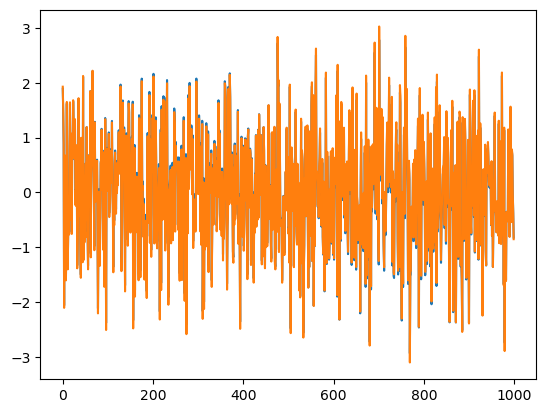

In [7]:
plt.plot(s_pred.detach().numpy())
plt.plot(s_obs)
plt.show()